In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')

## 1. Import packages

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torchvision.transforms as T

## 2. Prepare Data
1. download images
2. load image: open + resize + normalize

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def download(url, filename=None):
    import os
    from urllib.request import urlretrieve
    if filename is None:
        filename = url.split('/')[-1]
    if not os.path.exists(filename):
        print('Downloading {} from {}...'.format(filename, url))
        urlretrieve(url, filename=filename)
        
download('https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg')
download('https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg')
download('https://upload.wikimedia.org/wikipedia/commons/thumb/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg/800px-Green_Sea_Turtle_grazing_seagrass.jpg', filename='turtle.jpg')

def load_img(path, imsize=512):
    img = Image.open(path)
    transforms = T.Compose([
        T.Resize(imsize), # !!! add Resize to make sure two images are the same shape, so that content_img and style_img can produce the features with the shape, which further used for loss calculation
        T.CenterCrop(imsize), # !!! crop to change the image to (imsize, imsize)
        T.ToTensor()
    ])
    return transforms(img).unsqueeze(0).to(device)

style_img = load_img('picasso.jpg')
# content_img = load_img('dancing.jpg')
content_img = load_img('turtle.jpg')
input_img = content_img.clone()


def imshow(img):
    '''
        img: torch.Tensor. C x H x W
    '''
    plt.figure()
    img = img.cpu().clone()
    plt.imshow(T.ToPILImage()(img))
    plt.show()


## 3. Build model
1. Define content loss and style loss: loss function + preprocessing(style loss requires gram matrix)
2. Add the Loss layer to the exisiting layers in pretrained model. Note that the Loss layer does not process the input tensor, but feed the input tensor into the loss function which further computes the loss given the input tensor and the pre-stored target tensor. For style loss layer, the target image is the gram matrix of style image, while content loss requires content image.

In this case, the resulting model structure is showed as follows:
```
Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss()
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_4): ContentLoss()
  (style_loss_4): StyleLoss()
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_5): StyleLoss()
)
```

In [0]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
std = torch.tensor([0.229, 0.224, 0.225]).to(device)

def gram_matrix(input):
    '''
        input: (batch_size, num_channels, height, weight)
    '''
    batch_size, num_channels, height, weight = input.size()
    features = input.view(batch_size * num_channels, height * weight)
    G = torch.mm(features, features.t())
    return G.div(batch_size * num_channels * height * weight)
    

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = mean.view(-1, 1, 1)
        self.std = std.view(-1, 1, 1)
        
    def forward(self, img):
        return (img - self.mean) / self.std

class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        
    def forward(self, input):
#         print('input.shape:', input.shape)
#         print('self.target.shape:', self.target.shape)
        self.loss = F.mse_loss(input, self.target)
        return input

      
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input



def get_model(cnn, mean, std, content_img, style_img):
    content_layer_default = ['conv_4']
    style_layer_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
    
    style_losses = list()
    content_losses = list()

    model = nn.Sequential(Normalization(mean, std).to(device))
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_' + '%d'%(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_' + '%d'%(i)
            layer = nn.ReLU(inplace=False) # !!! needed. If removed, the program reports error that says 'one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [128, 65536]], which is output 0 of ViewBackward, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).'
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_' + '%d'%(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_' + '%d'%(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layer_default:
            target = model(content_img).detach()
            content_loss = ContentLoss(target) # !!! not content_img.
            model.add_module('content_loss_%d'%(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layer_default:
            target = model(style_img).detach()
            style_loss = StyleLoss(target) # !!! not style_img
            model.add_module('style_loss_%d'%(i), style_loss)
            style_losses.append(style_loss)

    # trim off the layers after the final content or style loss layer
    i = 0
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], StyleLoss) or isinstance(model[i], ContentLoss): # !!! not instance(i, xxxLoss)
            break
    model = model[:(i + 1)]
    print(model)
    
    return model, content_losses, style_losses



## 4. Train

1. Keep the value of input image in `[0, 1]`

2. Compute the loss which is the weighted summation of style loss and content loss

3. update using LBFGS optimizer

Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss()
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_4): ContentLoss()
  (style_loss_4): StyleLoss()
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_5): StyleLoss()
)
Epoch [50] || Style Loss: 5.619109651888721e-05 Content Loss: 12.106857299804688
Epoch [100] || Style Loss: 2.1596057194983587e-05 Cont

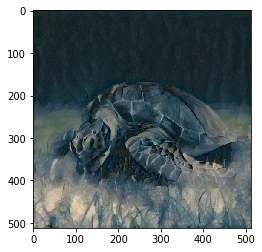

In [5]:
def run_style_transfer(cnn, mean, std, content_img, style_img, input_img, num_epochs=300, style_weight=1000000, content_weight=1):
    model, content_losses, style_losses = get_model(cnn, mean, std, content_img, style_img)
    optimizer = torch.optim.LBFGS([input_img.requires_grad_()])

    epoch = [0] # Use list so that the closure function can modify the value
    while epoch[0] <= num_epochs:
        def closure():
            # zero_grad + backward + return loss
            input_img.data.clamp_(0, 1) # !!! not input_img.clamp_
            optimizer.zero_grad()
            model(input_img)

            content_loss = 0
            style_loss = 0
            for layer in content_losses:
                content_loss += layer.loss
            for layer in style_losses:
                style_loss += layer.loss
            
            loss = content_weight * content_loss + style_weight * style_loss
            loss.backward()
            
            epoch[0] += 1
            if epoch[0] % 50 == 0:
                print('Epoch {} || Style Loss: {} Content Loss: {}'.format(epoch, style_loss.item(), content_loss.item()))

            return loss

        optimizer.step(closure)
    input_img.data.clamp_(0, 1) # !!! not input_img.clamp_, otherwise reports 'a leaf Variable that requires grad has been used in an in-place operation' error
    return input_img

output = run_style_transfer(cnn, mean, std, content_img, style_img, input_img)
imshow(output.squeeze(0))

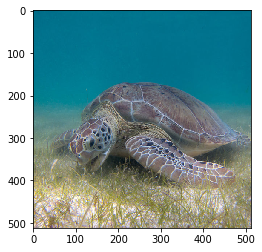

In [6]:
imshow(content_img.squeeze(0))